In [1]:
pwd

'C:\\Users\\admin\\Downloads'

# imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
import xarray as xr
import sys
from tqdm.notebook import tqdm
from time import time
from glob import glob
from os.path import exists
!pip install dask cuda-python

# load data

In [3]:
file = r'/content/drive/Shareddrives/Fluctuation Mapping/data/reduced_data/232.0K_reduced.h5'
file = r'./data/232.0K_reduced.h5'
ds = xr.open_dataset(file)
temp = ds.temperature
ds

<xarray.Dataset>
Dimensions:      (time: 1817, row: 800, col: 800)
Coordinates:
  * time         (time) int32 0 1 2 3 4 5 6 ... 1811 1812 1813 1814 1815 1816
  * row          (row) int32 0 1 2 3 4 5 6 7 ... 792 793 794 795 796 797 798 799
  * col          (col) int32 0 1 2 3 4 5 6 7 ... 792 793 794 795 796 797 798 799
Data variables:
    image_stack  (time, row, col) float32 ...
Attributes:
    temperature:  232.0

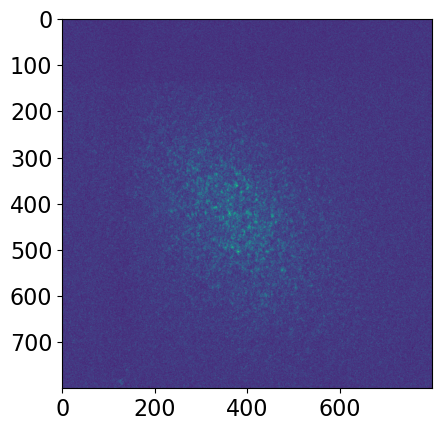

In [4]:
img = ds['image_stack'][1].compute().to_numpy()
plt.figure()
plt.imshow(img)
plt.show()

In [5]:
imgs = ds['image_stack'].compute().to_numpy()
imgs.shape

(1817, 800, 800)

In [6]:
from numba import cuda, float32
import numpy as np
import math
from cuda.cuda import CUdevice_attribute, cuDeviceGetAttribute, cuDeviceGetName, cuInit
import dask.array as da

# Initialize CUDA Driver API
(err,) = cuInit(0)

# Get attributes
err, DEVICE_NAME = cuDeviceGetName(128, 0)
DEVICE_NAME = DEVICE_NAME.decode("ascii").replace("\x00", "")

err, MAX_THREADS_PER_BLOCK = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK, 0
)
err, MAX_BLOCK_DIM_X = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MAX_BLOCK_DIM_X, 0
)
err, MAX_GRID_DIM_X = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MAX_GRID_DIM_X, 0
)
err, SMs = cuDeviceGetAttribute(
    CUdevice_attribute.CU_DEVICE_ATTRIBUTE_MULTIPROCESSOR_COUNT, 0
)

@cuda.jit
def nb_cuda_g2(img_stack, g2):
    tau, row, col = cuda.grid(3)
    # print(tau, row, col)
    if tau < g2.shape[0] and row < g2.shape[1] and col < g2.shape[2]:
        d = img_stack.shape[0]
        for t in range(d - tau):
            g2[tau, row, col] += img_stack[t, row, col] * img_stack[t + tau, row, col]
        t_sum = 0
        for t in range(d):
            t_sum += img_stack[t, row, col]
        g2[tau, row, col] = g2[tau, row, col] / (d - tau) / (t_sum / d)**2

# TODO: if data size exceeds gpu memory limits add outer function to split data and perform multiple cuda calls

def host_nb_cuda_g2(img_stack, threadsperblock=(MAX_THREADS_PER_BLOCK//10//10, 10, 10)):
    if not img_stack.size:
        return
    g2 = np.zeros_like(img_stack)
    blockspergrid = tuple(map(int, np.ceil(img_stack.shape/np.array(threadsperblock))))
    dev_data = cuda.to_device(np.ascontiguousarray(img_stack))
    dev_g2 = cuda.to_device(g2)
    print('Blocks in grid:', blockspergrid)
    print('Threads per block:', threadsperblock)
    nb_cuda_g2[blockspergrid, threadsperblock](dev_data, dev_g2)
    g2 = dev_g2.copy_to_host()
    return g2


def dask_nb_cuda_g2(img_stack, threadsperblock=(MAX_THREADS_PER_BLOCK//10//10, 10, 10), xy_chunks=None):
    if xy_chunks is None:
      block_size = int((MAX_GRID_DIM_X/img_stack.shape[0])**.5)   # NOTE: time dimension must be less than max block size here
      xy_chunks = (block_size, block_size)

    dask_imgs = da.from_array(img_stack, chunks=(-1, *xy_chunks))
    print('Dask chunks/cuda grids:', dask_imgs.blocks.shape)

    g2 = dask_imgs.map_blocks(host_nb_cuda_g2, dtype=np.single, threadsperblock=threadsperblock)
    return g2.compute()

In [7]:
# calculate g2

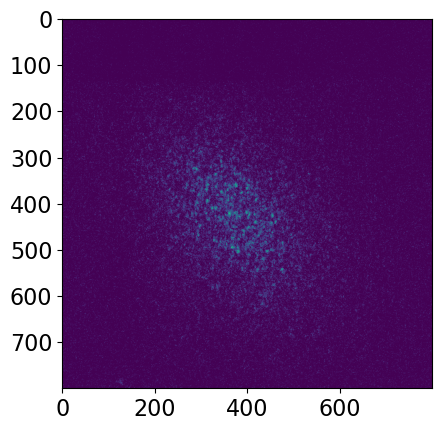

In [8]:
thresh = np.percentile(imgs[1:100].mean(axis=0), 70)
plt.imshow(np.maximum(imgs[10], thresh))

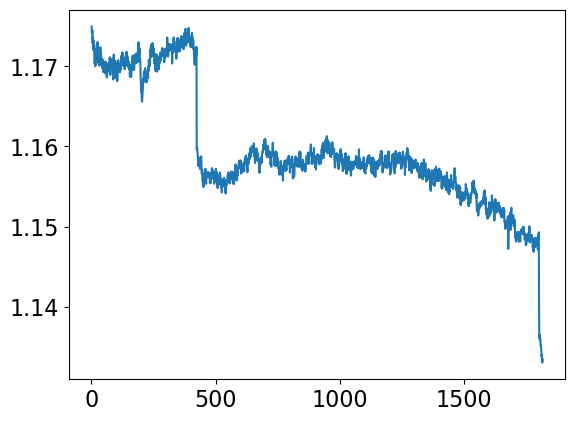

In [34]:
intensity = np.maximum(imgs, thresh).mean(axis=(1,2))
plt.figure()
plt.plot(intensity)
plt.show()

In [51]:
%%time
# Host code
g2_dask_nb_cuda = dask_nb_cuda_g2(imgs)

Dask chunks/cuda grids: (1, 1, 1)
Blocks in grid: (182, 80, 80)
Threads per block: (10, 10, 10)
CPU times: total: 1min 24s
Wall time: 1min 24s


In [52]:
g2_dask_nb_cuda.shape

(1817, 800, 800)

In [53]:
ds = xr.Dataset(
        data_vars={'g2_stack': (('g2', 'row', 'col'), g2_dask_nb_cuda)},
        coords={
            'lags': np.arange(g2_dask_nb_cuda.shape[0]),
            'row': np.arange(g2_dask_nb_cuda.shape[1]),
            'col': np.arange(g2_dask_nb_cuda.shape[2]),
        },
        attrs=dict(temperature=temp)
)

In [54]:
ds

<xarray.Dataset>
Dimensions:   (g2: 1817, row: 800, col: 800, lags: 1817)
Coordinates:
  * lags      (lags) int32 0 1 2 3 4 5 6 ... 1810 1811 1812 1813 1814 1815 1816
  * row       (row) int32 0 1 2 3 4 5 6 7 8 ... 792 793 794 795 796 797 798 799
  * col       (col) int32 0 1 2 3 4 5 6 7 8 ... 792 793 794 795 796 797 798 799
Dimensions without coordinates: g2
Data variables:
    g2_stack  (g2, row, col) float32 1.02 1.024 1.023 1.027 ... nan nan nan nan
Attributes:
    temperature:  232.0

In [56]:
out_file = f'./data/{temp}K_g2.h5'
ds.to_netcdf(out_file, engine='h5netcdf')

# loop

In [9]:
files = sorted(glob('./data/*reduced.h5'))
files

['./data\\200.0K_reduced.h5',
 './data\\225.0K_reduced.h5',
 './data\\230.0K_reduced.h5',
 './data\\230.5K_reduced.h5',
 './data\\231.0K_reduced.h5',
 './data\\232.0K_reduced.h5']

In [ ]:
for file in tqdm(files):
    ds = xr.open_dataset(file)
    temp = ds.temperature    
    out_file = f'./data/{temp}K_g2.h5'
    if exists(out_file):
        continue
    
    imgs = ds['image_stack'].compute().to_numpy()
    g2_dask_nb_cuda = dask_nb_cuda_g2(imgs)
    
    ds_g2 = xr.Dataset(
        data_vars={'g2_stack': (('g2', 'row', 'col'), g2_dask_nb_cuda)},
        coords={
            'lags': np.arange(g2_dask_nb_cuda.shape[0]),
            'row': np.arange(g2_dask_nb_cuda.shape[1]),
            'col': np.arange(g2_dask_nb_cuda.shape[2]),
        },
        attrs=dict(temperature=temp)
        )
    ds_g2.to_netcdf(out_file, engine='h5netcdf')

  0%|          | 0/6 [00:00<?, ?it/s]

Dask chunks/cuda grids: (1, 1, 1)
Blocks in grid: (234, 80, 80)
Threads per block: (10, 10, 10)
